In [2]:
from logaut import ltl2dfa
# Python imports, put at the top for simplicity
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service, print_policy_data, \
    print_value_function, print_q_value_function
from stochastic_service_composition.declare_utils import exactly_once, absence_2, alt_succession, alt_precedence, \
    build_declare_assumption, not_coexistence
from stochastic_service_composition.dfa_target import mdp_from_dfa
from stochastic_service_composition.momdp import compute_final_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service


In [3]:
# default economic cost value
DEFAULT_REWARD_ECONOMIC_COST = -1.0

# default quality cost value
DEFAULT_REWARD_QUALITY_COST = -1.0

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = 0.0

# default probability of being broken after an action
DEFAULT_BROKEN_PROB = 0.05

# default discount factor
GAMMA = 0.99

In [4]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

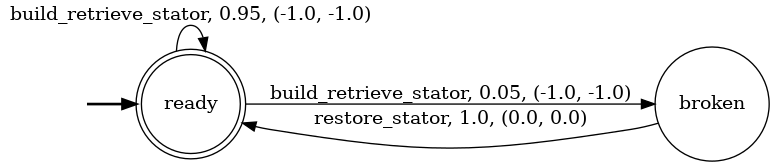

In [5]:
def stator_builder_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "ready": {
          BUILD_RETRIEVE_STATOR: ({"ready": success_prob, "broken": broken_prob}, (economic_cost, quality_cost)),
        },
        "broken": {
            "restore_stator": ({"ready": 1.0}, (broken_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore
service_stator_builder=stator_builder_service()
render_service(service_stator_builder)

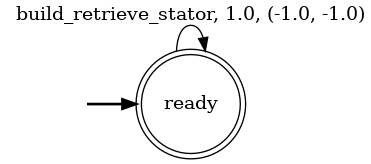

In [6]:
def stator_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_STATOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_stator_warehouse=stator_warehouse_service()
render_service(service_stator_warehouse)

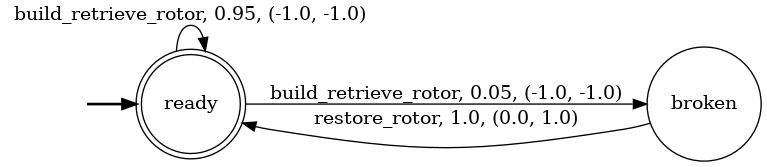

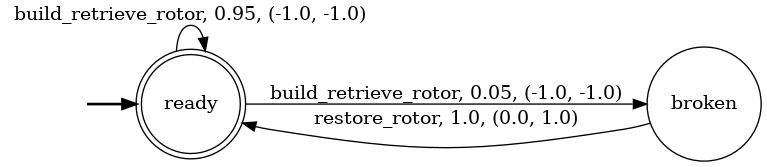

In [7]:
def rotor_builder_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the rotor builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "ready": {
          BUILD_RETRIEVE_ROTOR: ({"ready": success_prob, "broken": broken_prob}, (economic_cost, quality_cost)),
        },
        "broken": {
            "restore_rotor": ({"ready": 1.0}, (broken_reward, 1.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

service_rotor_builder_1 = rotor_builder_service()
service_rotor_builder_2 = rotor_builder_service()

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

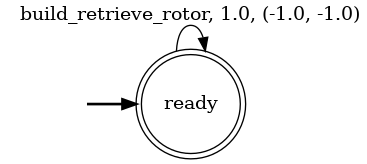

In [8]:
def rotor_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the rotor warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_ROTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_rotor_warehouse = rotor_warehouse_service()
render_service(service_rotor_warehouse)

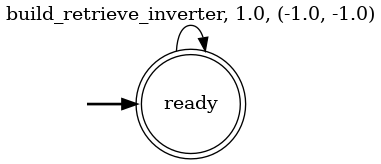

In [9]:
def inverter_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the inverter warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_INVERTER: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_inverter_warehouse=inverter_warehouse_service()
render_service(service_inverter_warehouse)

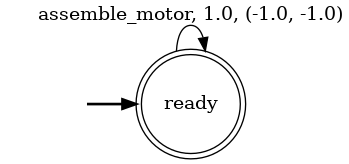

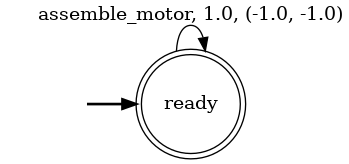

In [10]:
def assembler_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the assembler device."""
    transitions = {
        "ready": {
            ASSEMBLE_MOTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_assembler_1 = assembler_service()
service_assembler_2 = assembler_service()
render_service(service_assembler_1)
render_service(service_assembler_2)

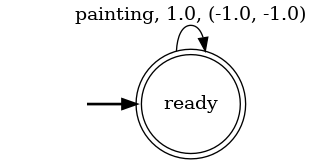

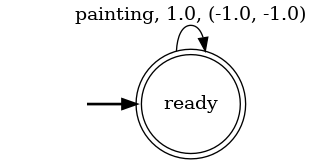

In [11]:
def painter_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the painter device."""
    transitions = {
        "ready": {
            PAINTING: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_painter_1 = painter_service()
service_painter_2 = painter_service()

render_service(service_painter_1)
render_service(service_painter_2)

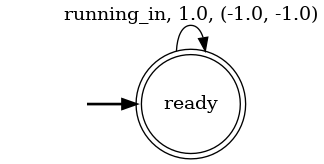

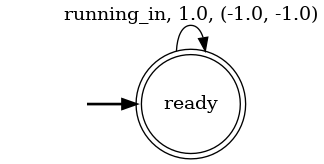

In [12]:
def smart_tester_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the smart tester device."""
    transitions = {
        "ready": {
            RUNNING_IN: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_smart_tester_1 = smart_tester_service()
service_smart_tester_2 = smart_tester_service()

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

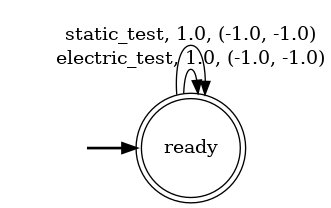

In [13]:
def mechanical_engineer_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the mechanical engineer device."""
    transitions = {
        "ready": {
            ELECTRIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
            STATIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_mechanical_engineer = mechanical_engineer_service()
render_service(service_mechanical_engineer)

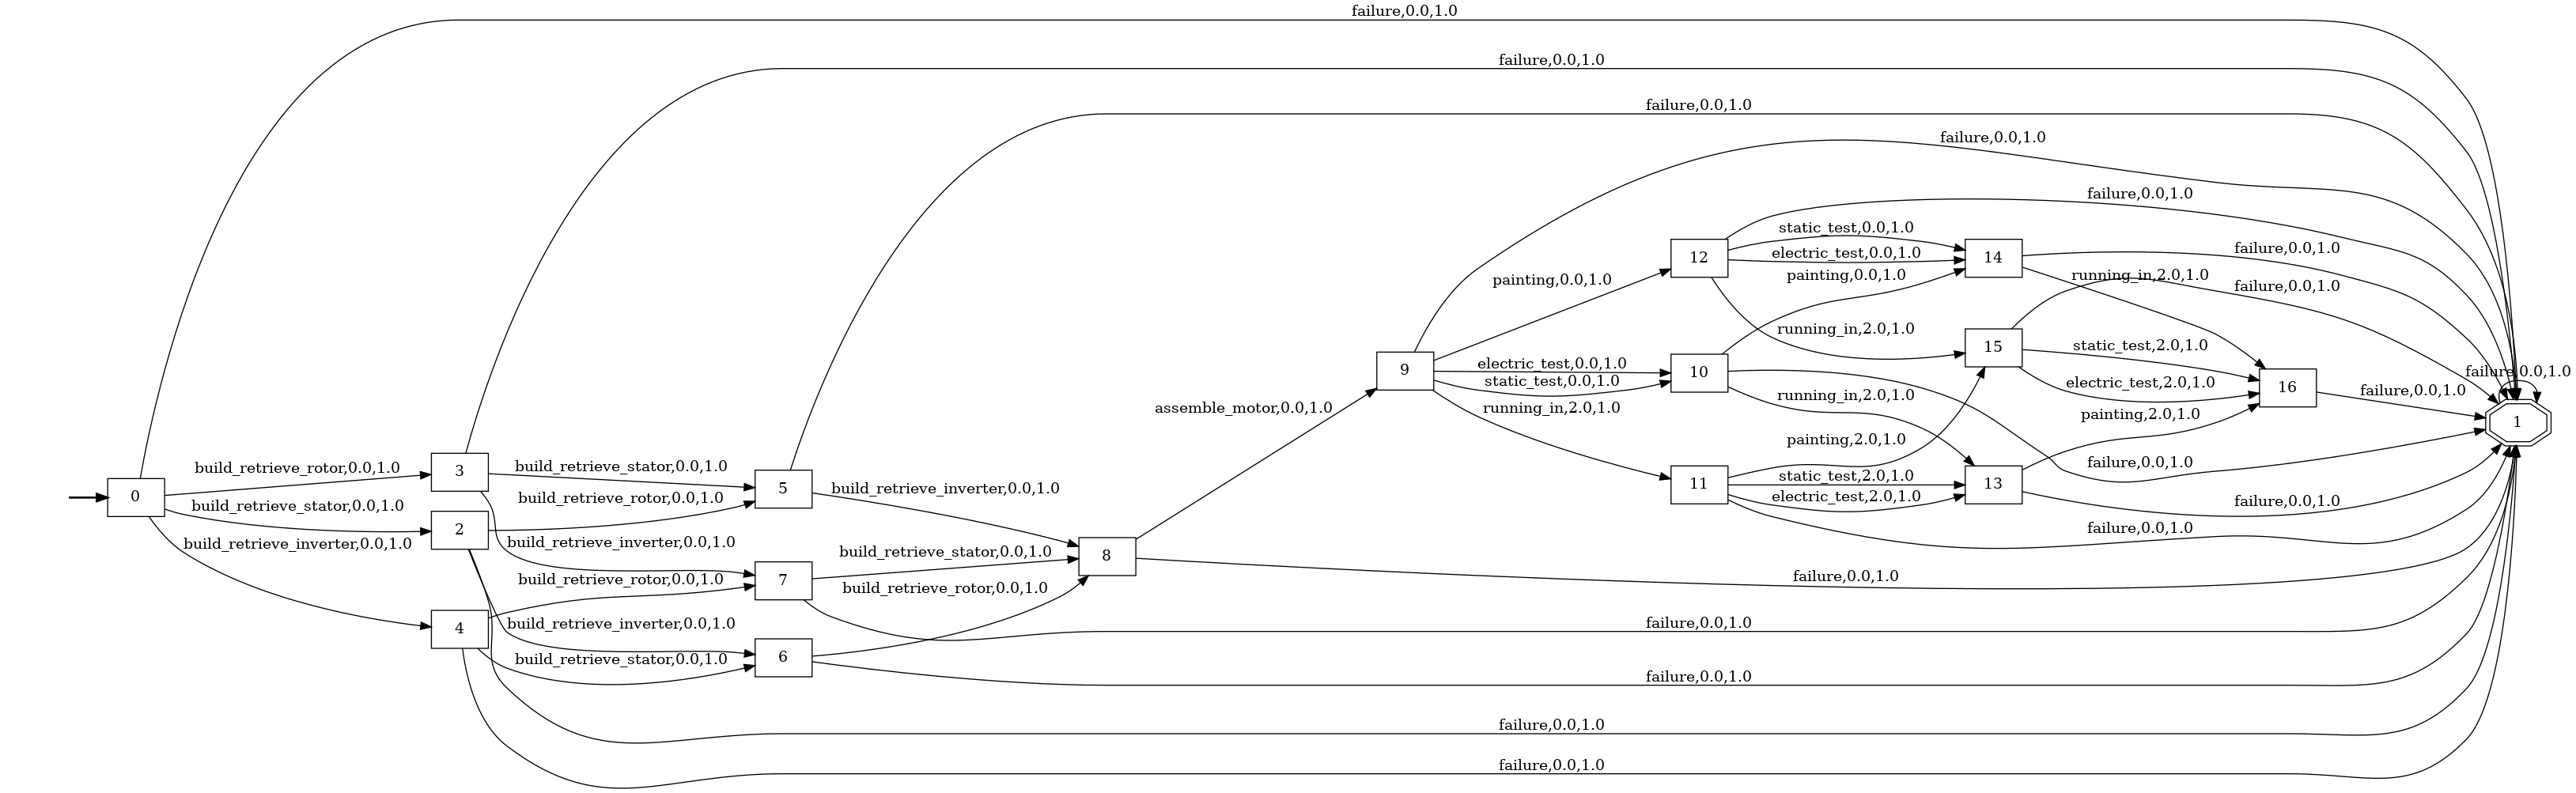

In [14]:

declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]
formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
target_mdp = mdp_from_dfa(automaton, gamma=GAMMA)
render_mdp_dfa(target_mdp)

In [15]:
all_services = [
    service_stator_builder,
    service_stator_warehouse,
    service_rotor_builder_1,
    service_rotor_builder_2,
    service_rotor_warehouse,
    service_inverter_warehouse,
    service_assembler_1,
    service_assembler_2,
    service_painter_1,
    service_painter_2,
    service_smart_tester_1,
    service_smart_tester_2,
    service_mechanical_engineer,
]

weights = [10.0, 2.0, 1.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
# render_mdp_dfa(final_mdp)

In [16]:
len(final_mdp.all_states)

80

In [17]:
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
_ = q_value_function.pop(0, None)

In [21]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_rotor', 2)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_rotor', 2)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 6)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 10)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 10)
State=(('broken', 'read

In [19]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-270.79391610290617
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-274.53930919485475
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-217.56723618072647
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-216.73458200073367
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-215.89351717245833
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-235.24597694187713
State=(('broken', 'ready', 'broken

In [20]:
print_q_value_function(q_value_function)

Q-value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1):
	Action=('assemble_motor', 6),	Value=-271.0859769418771
	Action=('assemble_motor', 7),	Value=-271.0859769418771
	Action=('build_retrieve_inverter', 5),	Value=-271.0859769418771
	Action=('build_retrieve_rotor', 4),	Value=-271.0859769418771
	Action=('build_retrieve_stator', 1),	Value=-271.0859769418771
	Action=('electric_test', 12),	Value=-271.0859769418771
	Action=('painting', 8),	Value=-271.0859769418771
	Action=('painting', 9),	Value=-271.0859769418771
	Action=('restore_rotor', 2),	Value=-270.7939161029062
	Action=('restore_rotor', 3),	Value=-270.7939161029062
	Action=('restore_stator', 0),	Value=-270.8138161029062
	Action=('running_in', 10),	Value=-271.0859769418771
	Action=('running_in', 11),	Value=-271.0859769418771
	Action=('static_test', 12),	Value=-271.0859769418771

State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 